In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [11]:
image_size = (224, 224)
batch_size = 32
train_dir = 'data/train'
test_dir = 'data/test'

2.19.0


In [13]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 711 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


In [14]:
model = models.Sequential([
    layers.Input(shape=(*image_size, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_data.num_classes, activation='softmax')
])

In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3278 - loss: 2.2006 - val_accuracy: 0.3596 - val_loss: 1.0779
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4249 - loss: 1.0688 - val_accuracy: 0.4649 - val_loss: 1.0357
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 997ms/step - accuracy: 0.5012 - loss: 1.0053 - val_accuracy: 0.5000 - val_loss: 1.0080
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6759 - loss: 0.7401 - val_accuracy: 0.5614 - val_loss: 1.0084
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7798 - loss: 0.5477 - val_accuracy: 0.5877 - val_loss: 1.0899
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8680 - loss: 0.3658 - val_accuracy: 0.5702 - val_loss: 1.3002
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 938ms/step - accuracy: 0.9118 - loss: 0.2213 - val_accuracy: 0.5789 - val_loss: 1.6285
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9674 - loss: 0.1311 - val_accuracy: 0.5351 - val

In [18]:
# Get true labels and predictions
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


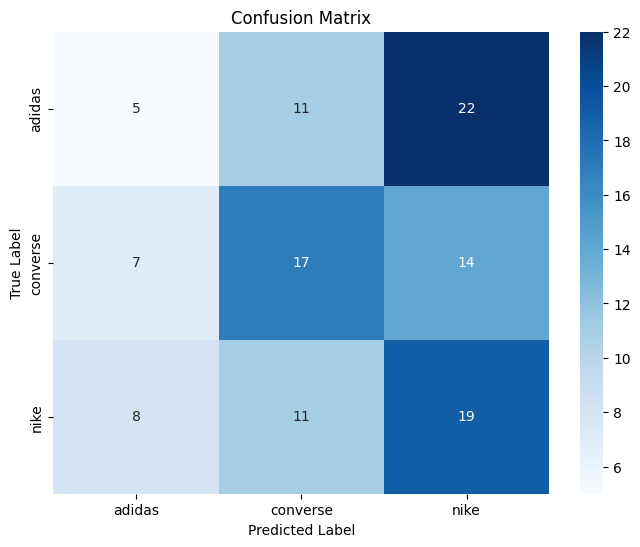

In [19]:
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_data.class_indices.keys())

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [20]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      adidas       0.25      0.13      0.17        38
    converse       0.44      0.45      0.44        38
        nike       0.35      0.50      0.41        38

    accuracy                           0.36       114
   macro avg       0.34      0.36      0.34       114
weighted avg       0.34      0.36      0.34       114

